In [1]:
import autoroot
import xarray as xr
import numpy as np
import pandas as pd
import scipy 
import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

In [2]:
def plot_3d(x, y, p, label='$z$', elev=30.0, azim=45.0):
    """
    Creates a Matplotlib figure with a 3D surface plot
    of the scalar field p.

    Parameters
    ----------
    x : numpy.ndarray
        Gridline locations in the x direction as a 1D array of floats.
    y : numpy.ndarray
        Gridline locations in the y direction as a 1D array of floats.
    p : numpy.ndarray
        Scalar field to plot as a 2D array of floats.
    label : string, optional
        Axis label to use in the third direction;
        default: 'z'.
    elev : float, optional
        Elevation angle in the z plane;
        default: 30.0.
    azim : float, optional
        Azimuth angle in the x,y plane;
        default: 45.0.
    """
    fig, ax = plt.subplots(figsize=(8.0, 6.0), subplot_kw={"projection": "3d"})
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel(label)
    X, Y = np.meshgrid(x, y)
    surf = ax.plot_surface(X, Y, p, cmap=cm.viridis)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(y[0], y[-1])
    ax.view_init(elev=elev, azim=azim)
    plt.tight_layout()
    plt.colorbar(surf, shrink=0.5, aspect=5)

## Read input SSH

In [3]:
def l2_norm(p, p_ref, **kwargs):
    """
    Computes and returns the relative L2-norm of the difference
    between a solution p and a reference solution p_ref.

    Parameters
    ----------
    p : numpy.ndarray
        The solution as an array of floats.
    p_ref : numpy.ndarray
        The reference solution as an array of floats.

    Returns
    -------
    diff : float
        The relative L2-norm of the difference.
    """
    l2_diff = np.linalg.norm(p - p_ref, **kwargs) / np.linalg.norm(p_ref, **kwargs)
    return l2_diff

In [4]:
ds = xr.open_dataset('/Users/eman/code_projects/data/scratch/NATL60_GULFSTREAM_degraded.nc')
ds = xr.open_dataset('/Users/eman/code_projects/data/scratch/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc', decode_times=False).assign_coords(time=lambda ds: pd.to_datetime(ds.time))

# ds = ds.coarsen(lon=3,lat=3).mean()
ds

<xarray.Dataset>
Dimensions:  (time: 365, lat: 201, lon: 201)
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2012-10-01 2012-10-02 ... 2013-09-30
Data variables:
    ssh      (time, lat, lon) float64 ...

In [5]:
lon = ds.lon.values
lat = ds.lat.values
# ssh = ds.sossheig[0].values
ssh = ds.ssh[0].values


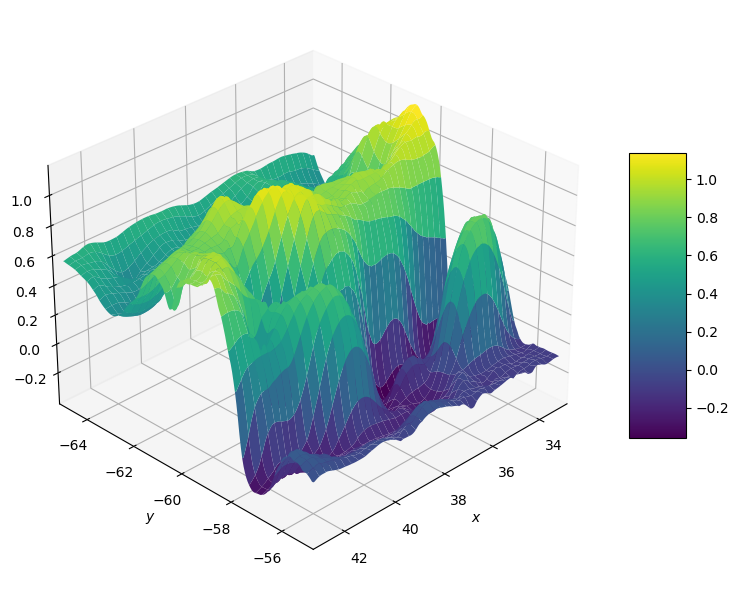

In [6]:
plot_3d(lat, lon, ssh)

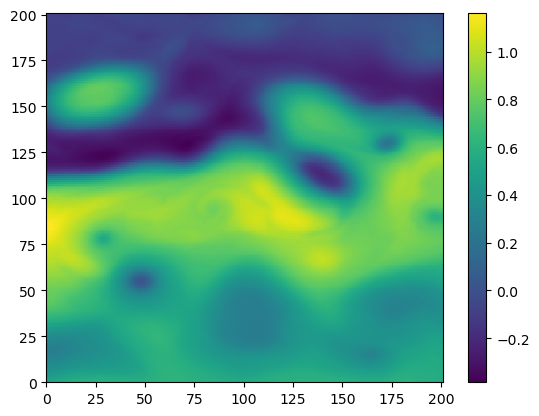

In [7]:
plt.figure()
plt.pcolormesh(ssh)
plt.colorbar()

## Forward elliptical equation: get PV from SSH on cartesian grid

$$ q = \frac{g}{f_0} \nabla^ 2 \eta - \frac{g f_0^2}{c_1^2} \eta $$

In [8]:
import jaxsw._src.models.qg.qg_r as qg

In [10]:
dx, dy, f, _ = qg.lat_lon_deltas(lon, lat)
dx = np.asarray(np.mean(dx))
dy = np.asarray(np.mean(dy))
dx = dy = np.mean([dx,dy])
f0 = np.asarray(np.mean(f))

x = np.arange(0,dx*lon.size,dx)
y = np.arange(0,dy*lat.size,dy)

nx = lon.size
ny = lat.size
c1 = 2.7 # First baroclinic phase speed
g = 9.91 # Gravity

In [11]:
dx,dy,f0

(4967.799, 4967.799, array(8.967452e-05, dtype=float32))

In [12]:
# dx,dy = 4000, 4000 # meters
# x = np.arange(0,dx*lon.size,dx)
# y = np.arange(0,dy*lat.size,dy)

# nx = lon.size
# ny = lat.size


# # Constants 
# g = 9.91 # Gravity
# f0 = 1e-5 # Coriolis frequency
# c1 = 2.7 # First baroclinic phase speed

In [47]:
def _laplace(h):

        return (h[2:,1:-1]+h[:-2,1:-1]-2*h[1:-1,1:-1])/dy**2 + (h[1:-1,2:]+h[1:-1,:-2]-2*h[1:-1,1:-1])/dx**2

def ssh2pv(h, ssh_bv):
    
        q = np.zeros_like(h)
        
        q[1:-1,1:-1] = g/f0 * (_laplace(h) - (f0/c1)**2 * h[1:-1,1:-1])
        
        # Boundary condition
        q[0,:] = -g*f0/(c1**2) * ssh_bv[0,:]
        q[-1,:] = -g*f0/(c1**2) * ssh_bv[-1,:]
        q[:,0] = -g*f0/(c1**2) * ssh_bv[:,0]
        q[:,-1] = -g*f0/(c1**2) * ssh_bv[:,-1]
    
        return q



def compute_laplace_dst(nx, ny, dx, dy, dtype):
    """Discrete sine transform of the 2D centered discrete laplacian
    operator."""
    x, y = np.meshgrid(np.arange(1,nx-1, dtype=dtype),
                       np.arange(1,ny-1, dtype=dtype),
                       indexing='ij')
    return 2*((np.cos(np.pi/(nx-1)*x) - 1)/dx**2 + (np.cos(np.pi/(ny-1)*y) - 1)/dy**2)


$$
= 2\left(\cos\left(\frac{\pi n}{L_x}\right) + \cos\left(\frac{\pi m}{L_y}\right) - 2\right)
$$

$$
2\left(\cos\left(\frac{\pi n}{L_x}\right) + \cos\left(\frac{\pi m}{L_y}\right) - 2\right)
$$

In [53]:
x, y = np.meshgrid(np.arange(0, nx, dtype=dtype),
                       np.arange(0,ny, dtype=dtype),
                       indexing='ij')

out = 2*(np.cos((np.pi*x)/nx) + np.cos((np.pi*y)/ny) - 2)

x, y = np.meshgrid(np.arange(1, nx-1, dtype=dtype),
                       np.arange(1,ny-1, dtype=dtype),
                       indexing='ij')

out_ = 2*((np.cos(np.pi/(nx-1)*x) - 1)/dx**2 + (np.cos(np.pi/(ny-1)*y) - 1)/dy**2)
out.shape, out_.shape
np.testing.assert_array_equal(out[1:-1,1:-1], out_)

AssertionError: 
Arrays are not equal

Mismatched elements: 39601 / 39601 (100%)
Max absolute difference: 7.99804551
Max relative difference: 24674517.83870392
 x: array([[-4.885722e-04, -1.221371e-03, -2.442503e-03, ..., -3.996337e+00,
        -3.998046e+00, -3.999267e+00],
       [-1.221371e-03, -1.954170e-03, -3.175302e-03, ..., -3.997070e+00,...
 y: array([[-1.999553e-11, -4.998635e-11, -9.996283e-11, ..., -1.620010e-07,
        -1.620510e-07, -1.620810e-07],
       [-4.998635e-11, -7.997717e-11, -1.299536e-10, ..., -1.620310e-07,...

$$
= 2\left(\cos\left(\frac{\pi n}{L_x}\right) + \cos\left(\frac{\pi m}{L_y}\right) - 2\right)
$$

$$
2\left(\cos\left(\frac{\pi (n-1)}{L_x-1}\right) + \cos\left(\frac{\pi (m-1)}{L_y-1}\right) - 2\right)
$$

In [47]:
x, y = np.meshgrid(np.arange(1,nx-1, dtype=dtype),
                       np.arange(1,ny-1, dtype=dtype),
                       indexing='ij')

out = 2*(np.cos(np.pi/(nx-1)*x) - 1)/dx**2 + 2*(np.cos(np.pi/(ny-1)*y) - 1)/dy**2
out_ = 2*((np.cos(np.pi/(nx-1)*x) - 1)/dx**2 + (np.cos(np.pi/(ny-1)*y) - 1)/dy**2 - 2)

np.testing.assert_array_equal(out, out_)

nx, ny, out.shape, out_.shape

AssertionError: 
Arrays are not equal

Mismatched elements: 1521 / 1521 (100%)
Max absolute difference: 4.
Max relative difference: 0.16856965
 x: array([[   -19.729064,    -49.261842,    -98.280787, ...,  -6321.448277,
         -6370.467222,  -6400.      ],
       [   -49.261842,    -78.79462 ,   -127.813565, ...,  -6350.981055,...
 y: array([[   -23.729064,    -53.261842,   -102.280787, ...,  -6325.448277,
         -6374.467222,  -6404.      ],
       [   -53.261842,    -82.79462 ,   -131.813565, ...,  -6354.981055,...

In [52]:
axis_x = 0
axis_y = None
ssh.shape, ssh[axis_x, axis_y].shape

((201, 201), (1, 201))

## Inverse elliptical equation


This is bad:

$$
\begin{aligned}
\boldsymbol{\Delta}\mathbf{q} &=\mathbf{\psi} \\
\mathbf{q} &= \mathbf{f} 
\end{aligned}
$$

This is also bad:

$$
\begin{aligned}
\boldsymbol{\Delta}\mathbf{q} &=\mathbf{\psi} \\
\mathbf{q} &= \mathbf{0} 
\end{aligned}
$$

This is good:

$$
\begin{aligned}
\boldsymbol{\Delta}\mathbf{q} &=\mathbf{0} \\
\mathbf{q} &= \mathbf{f} 
\end{aligned}
$$

Technique de relevement.

**Sources**:
* [Blog Post](https://bthierry.pages.math.cnrs.fr/course-fem/lecture/boundary-conditions/dirichlet/)

In [37]:
norm = 'ortho'

dtype = 'float64' # 'float64'
ssh = ssh.astype(dtype)

In [54]:
slice_bx1 = slice(0,0) + slice(-2, -1)

TypeError: unsupported operand type(s) for +: 'slice' and 'slice'

In [67]:
temp = ssh[0,:]
slices = [slice(0,1), slice(None,None)]
temp2 = ssh[slices[0], slices[1]].squeeze()

In [68]:
np.testing.assert_array_equal(temp, temp2)

In [38]:
ssh = ssh.astype(dtype)
ssh_bv = ssh.copy()
ssh_bv[1:-1,1:-1] = 0
pv_ref = ssh2pv(ssh, ssh_bv)

In [39]:
# compute boundary contribution to PV
ssh_bv = np.copy(ssh)
ssh_bv[1:-1,1:-1] = 0
pv_bv = ssh2pv(ssh_bv, ssh_bv)

In [40]:
# remove the boundary effect on PV
pv_in = pv_ref[1:-1,1:-1] - pv_bv[1:-1,1:-1]

In [41]:
# Compute helmottz operator
laplace_dst = compute_laplace_dst(nx, ny, dx, dy, dtype)
helmoltz_dst = g/f0 * laplace_dst  - g*f0/c1**2

# Get pv from sine transform
pv_in_hat = scipy.fftpack.dst(scipy.fftpack.dst(pv_in,norm=norm, type=1).T, norm=norm, type=1).T


In [42]:
type(helmoltz_dst)

numpy.ndarray

In [43]:

# Inverse sine tranfrom to get reconstructed ssh
ssh_rec = np.zeros_like(ssh)
ssh_rec[1:-1,1:-1] = scipy.fftpack.idst(
        scipy.fftpack.idst(pv_in_hat/helmoltz_dst, norm=norm, type=1).T,
    norm=norm, type=1).T

In [44]:

# # add the boundary value on SSH
# ssh_rec += ssh_bv
# add the boundary value on SSH
ssh_rec[0,:] = ssh_bv[0,:]
ssh_rec[-1,:] = ssh_bv[-1,:]
ssh_rec[:,0] = ssh_bv[:,0]
ssh_rec[:,-1] = ssh_bv[:,-1]

In [45]:




print(np.max(np.abs(ssh_rec - ssh)))

1.1631011471055959


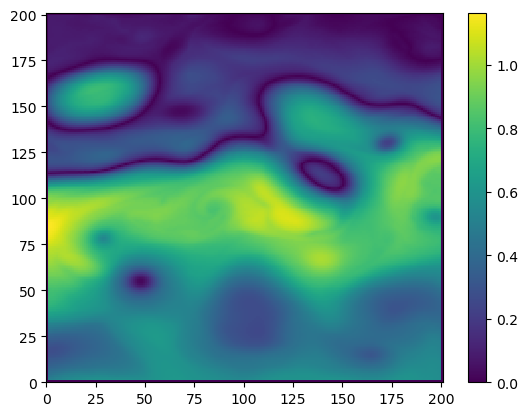

In [46]:
plt.figure()
plt.pcolormesh(np.abs(ssh-ssh_rec))
plt.colorbar()

**Simple**

$$
\begin{aligned}
b(x,y) &= 
-2\left(\frac{\pi^2}{L_x L_y}\right)
\sin\left(\frac{\pi x}{L_x}\right)
\cos\left( \frac{\pi y}{L_y}\right) \\
p(x,y) &= 
\sin\left(\frac{\pi x}{L_x}\right)
\cos\left( \frac{\pi y}{L_y}\right)
\end{aligned}
$$


$$
b(x,y) = 
\sin\left(\frac{\pi x}{L_x}\right)
\cos\left( \frac{\pi y}{L_y}\right) +
\sin\left( \frac{6\pi x}{L_x} \right)
\cos\left( \frac{6\pi y}{L_y} \right)
$$

In [24]:
def poisson_source(x, y, Lx, Ly):
    X, Y = np.meshgrid(x, y)
    b = (-2.0 * np.pi / Lx * np.pi / Ly *
         np.sin(np.pi * X / Lx) *
         np.cos(np.pi * Y / Ly)
        )
    return b

def poisson_solution(x, y, Lx, Ly):
    X, Y = np.meshgrid(x, y)
    p = np.sin(np.pi * X / Lx) * np.cos(np.pi * Y / Ly)
    return p

In [25]:
# Set parameters.
nx = 41  # number of points in the x direction
ny = 41  # number of points in the y direction
xmin, xmax = 0.0, 1.0  # domain limits in the x direction
ymin, ymax = -0.5, 0.5  # domain limits in the y direction
Lx = (xmax - xmin)  # domain length in the x direction
Ly = (ymax - ymin)  # domain length in the y direction
dx = Lx / (nx - 1)  # grid spacing in the x direction
dy = Ly / (ny - 1)  # grid spacing in the y direction

x = np.linspace(xmin, xmax, num=nx)
y = np.linspace(ymin, ymax, num=ny)

In [26]:
b = poisson_source(x, y, Lx, Ly)

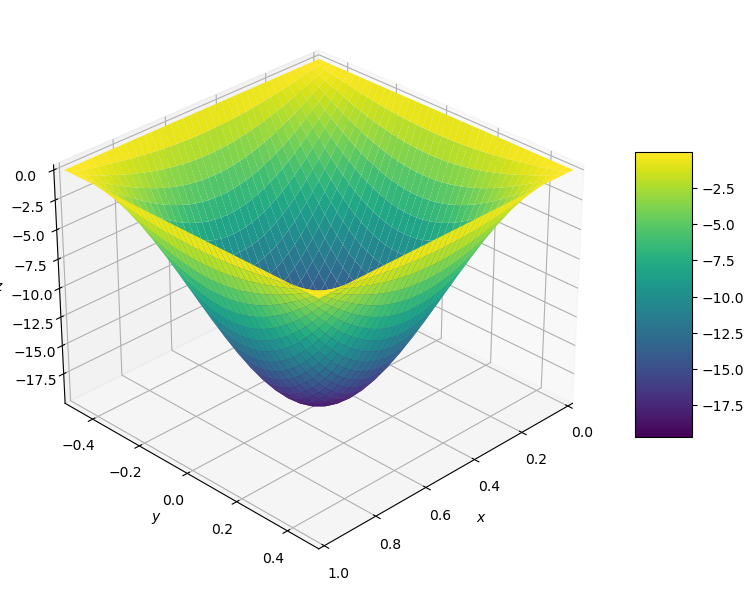

In [27]:
plot_3d(x, y, b)

In [28]:
# Get pv from sine transform
b_in = b[1:-1,1:-1]
b_in_hat = scipy.fftpack.dst(scipy.fftpack.dst(b_in,norm=norm, type=1).T, norm=norm, type=1).T

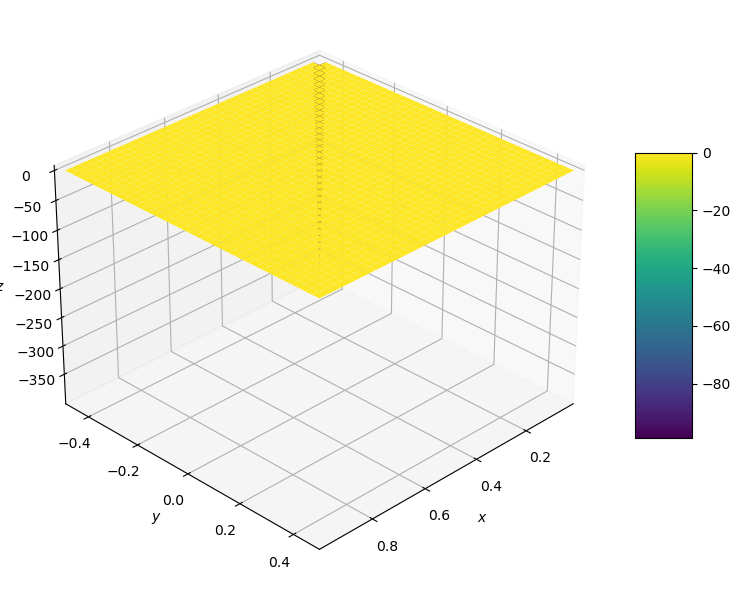

In [29]:
plot_3d(x[1:-1], y[1:-1], b_in_hat)

In [30]:
def compute_laplace_dst(nx, ny, dx, dy, dtype):
    """Discrete sine transform of the 2D centered discrete laplacian
    operator.
    """
    x, y = np.meshgrid(np.arange(1,nx-1, dtype=dtype),
                       np.arange(1,ny-1, dtype=dtype),
                       indexing='ij')
    return 2*(np.cos(np.pi/(nx-1)*x) - 1)/dx**2 + 2*(np.cos(np.pi/(ny-1)*y) - 1)/dy**2

# Compute helmottz operator
laplace_dst = compute_laplace_dst(nx, ny, dx, dy, dtype)

In [39]:
laplace_dst.shape, b_in_hat.shape

((39, 39), (39, 39))

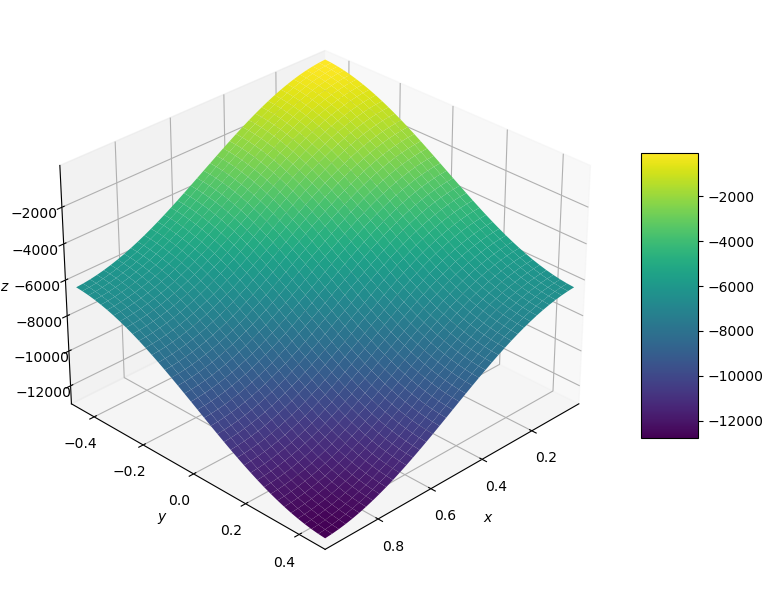

In [32]:
plot_3d(x[1:-1], y[1:-1], laplace_dst)

In [33]:

# Inverse sine tranfrom to get reconstructed ssh
p_rec = np.zeros_like(b)
p_rec[1:-1,1:-1] = scipy.fftpack.idst(
        scipy.fftpack.idst(b_in_hat/laplace_dst, norm=norm, type=1).T,
    norm=norm, type=1).T

In [34]:
p_true = poisson_solution(x, y, Lx, Ly)

In [35]:

# # add the boundary value on SSH
# ssh_rec += ssh_bv
# add the boundary value on SSH
p_rec[0,:] = p_true[0,:]
p_rec[-1,:] = p_true[-1,:]
p_rec[:,0] = p_true[:,0]
p_rec[:,-1] = p_true[:,-1]

In [36]:
l2_norm(p_rec, p_true)

0.0005142004781455846

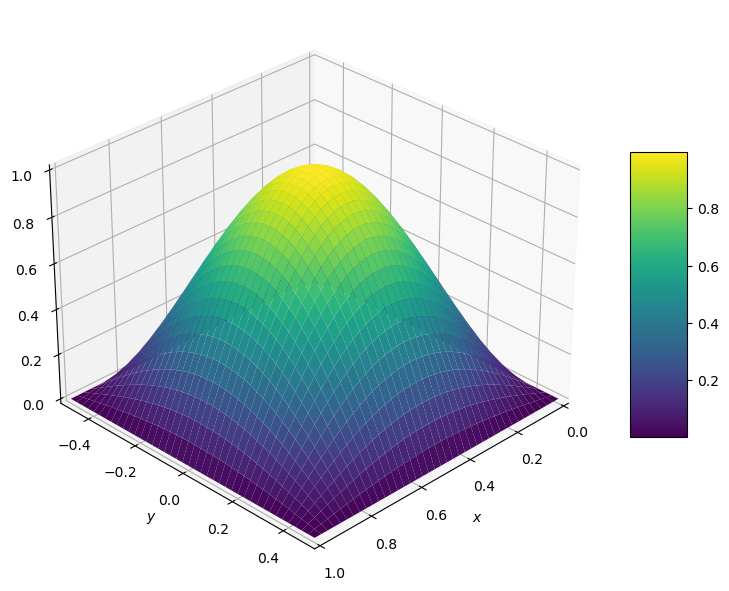

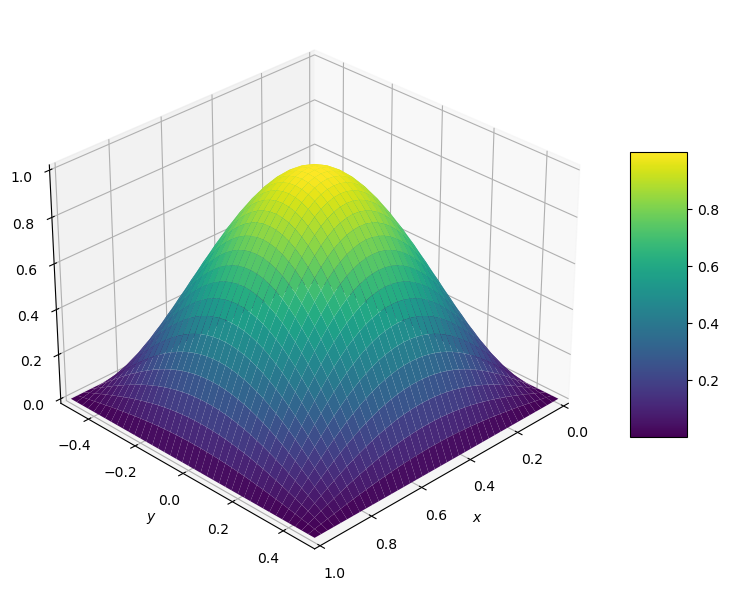

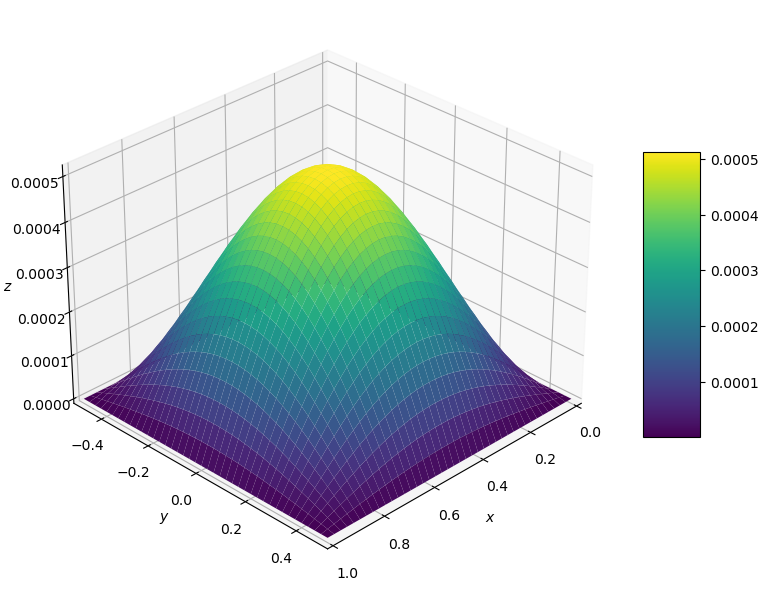

In [37]:
plot_3d(x, y, p_true)
plot_3d(x, y, p_rec)
plot_3d(x, y, np.abs(p_rec-p_true))

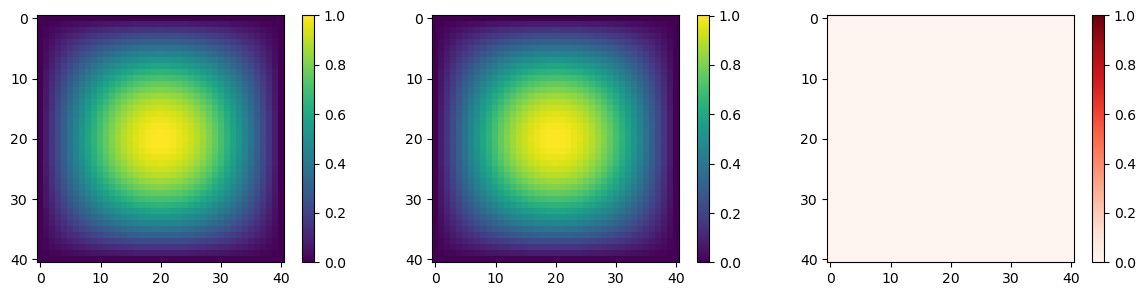

In [124]:
fig, ax = plt.subplots(ncols=3, figsize=(12,3))

pts=ax[0].imshow(p_true)
plt.colorbar(pts)
pts=ax[1].imshow(p_rec)
plt.colorbar(pts)
pts = ax[2].imshow(np.abs(p_true-p_rec), cmap="Reds", vmin=0.0, vmax=1.0)
plt.colorbar(pts)
plt.tight_layout()
plt.show()